<a href="https://colab.research.google.com/github/sumkh/ITI110_AgenticRAG/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PRE-PRODUCTION - AI Tutor Chatbot (Version 2.18)


### Setting Up - Install Requirements (Restart Session after installation)

In [1]:
%%capture
%pip install -qU vllm accelerate bitsandbytes langchain-openai langchain-groq huggingface_hub transformers langchain langchain_huggingface langgraph langchain-core langchain-text-splitters langchain-community chromadb langchain-chroma langsmith docling langchain-docling sentence_transformers gradio

### Load Packages and Utils

In [14]:
import os
from google.colab import userdata
LANGSMITH_API_KEY=userdata.get("LANGSMITH_API_KEY")
HF_TOKEN = userdata.get("HF_TOKEN")

os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenizers parallelism, as it causes issues with multiprocessing
os.environ["LANGCHAIN_TRACING_V2"] = "true" # LangSmith for Observability
os.environ["LANGCHAIN_PROJECT"] = "AgenticRAG"
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY # Optional

from huggingface_hub import login
login(token=HF_TOKEN) # May be optional for getting model download from Huggingface

# Download required files from Github repo
!wget https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip -o /content/Documents.zip


--2025-02-21 19:02:17--  https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip [following]
--2025-02-21 19:02:17--  https://raw.githubusercontent.com/sumkh/NYP_Dataset/refs/heads/main/Documents.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18510909 (18M) [application/zip]
Saving to: ‘Documents.zip.2’

Documents.zip.2     100%[===================>]  17.65M  --.-KB/s    in 0.1s    

2025-02-21 19:02:18 (164 MB/s) - ‘Documents.zip.2’ saved [18510909/18510909]

Archive:  /content/Do

In [15]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

In [16]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents


# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

# =============================================================================
#                         Vector Store Initialisation
# =============================================================================

embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


# =============================================================================
#                         Retrieval Tools
# =============================================================================

# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="Search topic.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 2) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.
    DO NOT GIVE THE ANSWERS to Human before Human has answered all the questions.

    If Human give answers for questions you do not know, SAY you do not have the questions for the answer
    and ASK if the Human want you to generate a new quiz and then SAVE THE QUIZ with Summary Tool before ending the conversation.


    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dict of MCQ questions:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="Search text.")
    url: str = Field(
        ...,
        title="url",
        description="Web URL(s) to extract content from. If multiple URLs, separate them with a comma."
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.
    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        "Assistant should use this tool to extract content from web URLs based on user's input, "
        "Web extraction is initially load into database and then return k: Number of results to retrieve"
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Ensemble Retrieval from General and In-Memory Vector Stores
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(5, title="Number of Results", description="Number of results.")

def ensemble_retriever(input: str, k: int = 5) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool to retrieve information from reference database and
    extraction of documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )


### Load vLLM Model and Serving Online using OpenAI Wrapper

#### Run vLLM SubProcess

In [ ]:
# https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#-tool-calling-(8b/70b/405b)-
# https://medium.com/@hakimnaufal/trying-out-vllm-deepseek-r1-in-google-colab-a-quick-guide-a4fe682b8665
# https://github.com/naufalhakim23/deepseek-r1-playground/blob/main/deepseek_r1_distill_qwen_fast_api.ipynb
# https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/vllm_inference_engine.ipynb
# https://docs.vllm.ai/_/downloads/en/v0.4.2/pdf/
# https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html
# https://docs.vllm.ai/en/latest/serving/env_vars.html
# https://docs.vllm.ai/en/latest/deployment/docker.html
# https://docs.vllm.ai/en/latest/features/quantization/bnb.html

# https://huggingface.co/casperhansen/llama-3-8b-instruct-awq/tree/main
# https://huggingface.co/unsloth/llama-3-8b-Instruct-bnb-4bit

!wget -q -P examples/ https://github.com/vllm-project/vllm/raw/refs/heads/main/examples/tool_chat_template_llama3.1_json.jinja

# we prepend "nohup" and postpend "&" to make the Colab cell run in background
! nohup python -m vllm.entrypoints.openai.api_server \
                  --model unsloth/llama-3-8b-Instruct-bnb-4bit \
                  --enable-auto-tool-choice \
                  --tool-call-parser llama3_json \
                  --chat-template examples/tool_chat_template_llama3.1_json.jinja \
                  --quantization bitsandbytes \
                  --load-format bitsandbytes \
                  --dtype half \
                  --max-model-len 8192 \
                  --download-dir models/vllm \
                  > vllm.log &

nohup: redirecting stderr to stdout


In [ ]:
# we check the logs until the server has been started correctly
!while ! grep -q "Application startup complete" vllm.log; do tail -n 1 vllm.log; sleep 5; done

INFO 02-19 17:24:35 api_server.py:206] Started engine process with PID 3503
WARNING 02-19 17:24:37 config.py:2386] Casting torch.bfloat16 to torch.float16.
E0000 00:00:1739985883.719463    3503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
WARNING 02-19 17:24:50 config.py:2386] Casting torch.bfloat16 to torch.float16.
WARNING 02-19 17:24:50 config.py:2386] Casting torch.bfloat16 to torch.float16.
WARNING 02-19 17:24:59 config.py:621] bitsandbytes quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 02-19 17:25:05 config.py:542] This model supports multiple tasks: {'reward', 'score', 'classify', 'embed', 'generate'}. Defaulting to 'generate'.
INFO 02-19 17:25:09 weight_utils.py:252] Using model weights format ['*.safetensors']
INFO 02-19 17:25:09 weight_utils.py:252] Using model weights format ['*.safetensors']
INFO 02-19 17:25:09 weight_utils.py:252]

find the process ID (PID) using a command like ps aux | grep vllm and then kill it using kill -9 <PID>.

In [ ]:
# Find the process ID (PID)
!ps aux | grep vllm

root        3440  3.5  8.5 6548852 1130792 ?     Sl   17:24   0:13 python3 -m vllm.entrypoints.opena
root        5378  0.0  0.0   7376  3452 ?        S    17:30   0:00 /bin/bash -c ps aux | grep vllm
root        5380  0.0  0.0   6484  2280 ?        S    17:30   0:00 grep vllm


In [ ]:
# To kill the process, look for the first set of digits
#!kill -9 2120

In [ ]:
import requests

def check_vllm_status():
    try:
        response = requests.get("http://localhost:8000/health")
        if response.status_code == 200:
            print("vllm server is running")
            return True
    except requests.exceptions.ConnectionError:
        print("vllm server is not running")
        return False

try:
    # Monitor the process
    while True:
        if check_vllm_status() == True:
            print("The vllm server is ready to serve.")
            break
        else:
            print("The vllm server has stopped.")
            stdout, stderr = vllm_process.communicate(timeout=10)
            print(f"STDOUT: {stdout.decode('utf-8')}")
            print(f"STDERR: {stderr.decode('utf-8')}")
            break
        time.sleep(5)  # Check every second
except KeyboardInterrupt:
    print("Stopping the check of vllm...")

vllm server is running
The vllm server is ready to serve.


In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="unsloth/llama-3-8b-Instruct-bnb-4bit",
    temperature=0.5,
    timeout=None,
    max_retries=2,
    api_key="not_required",
    base_url="http://localhost:8000/v1",
    # organization="...",
    # other params...
)

messages = [
    (
        "system",
        "You are a helpful assistant and study companion.",
    ),
    ("human", "Tell me a joke about Deep Learning."),
]
ai_msg = model.invoke(messages)
ai_msg

AIMessage(content='Why did the neural network go to therapy?\n\nBecause it had a lot of "hidden layers" and was struggling to "backpropagate" its emotions!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 52, 'total_tokens': 84, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'unsloth/llama-3-8b-Instruct-bnb-4bit', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-31488c76-daeb-4a16-a5fb-e222675c6d39-0', usage_metadata={'input_tokens': 52, 'output_tokens': 32, 'total_tokens': 84, 'input_token_details': {}, 'output_token_details': {}})

### Using Docker Image

In [ ]:
%%bash
docker run \
  --runtime nvidia --gpus all \
  --name ITI110_vllm_container \
  -v ~/.cache/huggingface:/root/.cache/huggingface \
  --env "HUGGING_FACE_HUB_TOKEN=$SECRETS/HF_TOKEN" \
  -p 8000:8000 \
  --ipc=host \
  -v /content/examples:/examples \ # Mount the directory
  vllm/vllm-openai:latest \
  vllm.entrypoints.openai.api_server \  # Start the vllm server explicitly
    --model unsloth/llama-3-8b-Instruct-bnb-4bit \
    --enable-auto-tool-choice \
    --tool-call-parser llama3_json \
    --chat-template examples/tool_chat_template_llama3.1_json.jinja \
    --quantization bitsandbytes \
    --load-format bitsandbytes \
    --dtype half \
    --max-model-len 8192 \
    --download-dir models/vllm \
    > vllm.log &

In [ ]:
# Load and run the model:
!docker exec -it my_vllm_container bash -c "vllm serve unsloth/llama-3-8b-Instruct-bnb-4bit"

In [ ]:
%%bash
# Call the server using curl:
curl -X POST "http://localhost:8000/v1/chat/completions" \
	-H "Content-Type: application/json" \
	--data {
		"model": "unsloth/llama-3-8b-Instruct-bnb-4bit",
		"messages": [
			{
				"role": "user",
				"content": "What is the capital of France?"
			}
		]
	}

### GROQ Serving (For Test References)

In [26]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

from langchain_groq import ChatGroq

# Initialize Groq LLM
model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",   #"llama-3.2-3b-preview", "deepseek-r1-distill-llama-70b"
    temperature=0.6,
    api_key=GROQ_API_KEY,
    verbose=True
)

print(model.invoke("Who are you?"))

content="<think>\n\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 7, 'total_tokens': 51, 'completion_time': 0.16, 'prompt_time': 0.00349463, 'queue_time': 0.234613626, 'total_time': 0.16349463}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_492bd52206', 'finish_reason': 'stop', 'logprobs': None} id='run-e002d566-6ff3-4a56-b48e-8029a69bfad1-0' usage_metadata={'input_tokens': 7, 'output_tokens': 44, 'total_tokens': 51}


### LangGraph

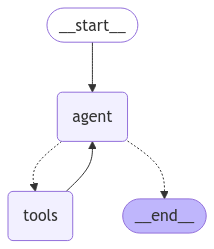

In [17]:
import json
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    List,
)

from pydantic import BaseModel, Field

# LangChain / LangGraph imports
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    BaseMessage,
    ToolMessage,
)
from langchain_core.tools import StructuredTool
from langchain_core.runnables import RunnableConfig

from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langchain.embeddings import init_embeddings
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

###############################################################################
# 1. Initialize memory + config
###############################################################################
in_memory_store = InMemoryStore(
    index={
        "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),
        "dims": 384,  # Embedding dimensions
    }
)

# A memory saver to checkpoint conversation states
checkpointer = MemorySaver()

# Initialize config with user & thread info
config = {}
config["configurable"] = {
    "user_id": "user_1",
    "thread_id": 0,
}

###############################################################################
# 2. Define MessagesState
###############################################################################
class MessagesState(TypedDict):
    """The state of the agent.

    The key 'messages' uses add_messages as a reducer,
    so each time this state is updated, new messages are appended.
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]


###############################################################################
# 3. Memory Tools
###############################################################################
def save_memory(summary_text: str, *, config: RunnableConfig, store: BaseStore) -> str:
    """Save the given memory for the current user and return the key."""
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    namespace = (user_id, "memories")
    memory_id = thread_id
    store.put(namespace, memory_id, {"memory": summary_text})
    return f"Saved to memory key: {memory_id}"

def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Extract the messages list from the event, handling potential missing key
    messages = state["messages"]
    # Convert LangChain messages to dictionaries before storing
    messages_dict = [{"role": msg.type, "content": msg.content} for msg in messages]

    # Get the user id from the config
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    # Namespace the memory
    namespace = (user_id, "memories")
    # Create a new memory ID
    memory_id = f"{thread_id}"
    store.put(namespace, memory_id, {"memory": messages_dict})
    return f"Saved to memory key: {memory_id}"


# Define a Pydantic schema for the save_memory tool (if needed elsewhere)
# https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.InMemoryStore.html
class RecallMemory(BaseModel):
    query_text: str = Field(..., title="Search Text", description="The text to search from memories for similar records.")
    k: int = Field(5, title="Number of Results", description="Number of results to retrieve.")

def recall_memory(query_text: str, k: int = 5) -> str:
    """Retrieve user memories from in_memory_store."""
    user_id = config.get("configurable", {}).get("user_id")
    memories = [
        m.value["memory"] for m in in_memory_store.search((user_id, "memories"), query=query_text, limit=k)
        if "memory" in m.value
    ]
    return f"User memories: {memories}"

# Create a StructuredTool from the function
recall_memory_tool = StructuredTool.from_function(
    func=recall_memory,
    name="Recall Memory Tool",
    description="""
      Retrieve memories relevant to the user's query.
      """,
    args_schema=RecallMemory,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 4. Summarize Node (using StructuredTool)
###############################################################################
# Define a Pydantic schema for the Summary tool
class SummariseConversation(BaseModel):
    summary_text: str = Field(..., title="text", description="Write a summary of entire conversation here")

def summarise_node(summary_text: str):
    """
    Final node that summarizes the entire conversation for the current thread,
    saves it in memory, increments the thread_id, and ends the conversation.
    Returns a confirmation string.
    """
    user_id = config["configurable"]["user_id"]
    current_thread_id = config["configurable"]["thread_id"]
    new_thread_id = str(int(current_thread_id) + 1)

    # Prepare configuration for saving memory with updated thread id
    config_for_saving = {
        "configurable": {
            "user_id": user_id,
            "thread_id": new_thread_id
        }
    }
    key = save_memory(summary_text, config=config_for_saving, store=in_memory_store)
    #return f"Summary saved under key: {key}"

# Create a StructuredTool from the function (this wraps summarise_node)
summarise_tool = StructuredTool.from_function(
    func=summarise_node,
    name="Summary Tool",
    description="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers so the next conversation thread can continue.
      Do not reveal solutions to the user yet. Use this tool to save
      the current conversation to memory and then end the conversation.
      """,
    args_schema=SummariseConversation,
    response_format="content",
    return_direct=False,
    verbose=True
)

def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})


###############################################################################
# 5. Build the Graph
###############################################################################
graph_builder = StateGraph(MessagesState)

# Use the built-in ToolNode from langgraph that calls any declared tools.
tools = [
    mcq_retriever_tool,
    web_extraction_tool,
    ensemble_retriever_tool,
    general_retriever_tool,
    in_memory_retriever_tool,
    recall_memory_tool,
    summarise_tool,
]

tool_node = ToolNode(tools=tools)
#end_node = ToolNode(tools=[summarise_tool])

# Wrap your model with tools
llm_with_tools = model.bind_tools(tools)

###############################################################################
# 6. The agent's main node: call_model
###############################################################################
def call_model(state: MessagesState, config: RunnableConfig):
    """
    The main agent node that calls the LLM with the user + system messages.
    Since our vLLM chat wrapper expects a list of BaseMessage objects,
    we convert any dict messages to HumanMessage objects.
    If the LLM requests a tool call, we'll route to the 'tools' node next
    (depending on the condition).
    """
    # Convert message dicts to HumanMessage instances if needed.
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(HumanMessage(content=m.get("content", ""), role=m.get("role", "user")))
        else:
            messages.append(m)

    # Invoke the LLM (with tools) using the converted messages.
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}



def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})

###############################################################################
# 7. Add Nodes & Edges, Then Compile
###############################################################################
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tools", tool_node)
#graph_builder.add_node("summary", call_summary)

# Entry point
graph_builder.set_entry_point("agent")

# def custom_tools_condition(llm_output: dict) -> str:
#     """Return which node to go to next based on the LLM output."""

#     # The LLM's JSON might have a field like {"name": "Recall Memory Tool", "arguments": {...}}.
#     tool_name = llm_output.get("name", None)

#     # If the LLM calls "Summary Tool", jump directly to the 'summary' node
#     if tool_name == "Summary Tool":
#         return "summary"

#     # If the LLM calls any other recognized tool, go to 'tools'
#     valid_tool_names = [t.name for t in tools]  # all tools in the main tool_node
#     if tool_name in valid_tool_names:
#         return "tools"

#     # If there's no recognized tool name, assume we're done => go to summary
#     return "__end__"

# graph_builder.add_conditional_edges(
#     "agent",
#     custom_tools_condition,
#     {
#         "tools": "tools",
#         "summary": "summary",
#         "__end__": "summary",
#     }
# )

# If LLM requests a tool, go to "tools", otherwise go to "summary"
graph_builder.add_conditional_edges("agent", tools_condition)
#graph_builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", "__end__": "summary"})
#graph_builder.add_conditional_edges("agent", lambda llm_output: "tools" if llm_output.get("name", None) in [t.name for t in tools] else "summary", {"tools": "tools", "__end__": "summary"}

# If we used a tool, return to the agent for final answer or more tools
graph_builder.add_edge("tools", "agent")
#graph_builder.add_edge("agent", "summary")
#graph_builder.set_finish_point("summary")

# Compile the graph with checkpointing and persistent store
graph = graph_builder.compile(checkpointer=checkpointer, store=in_memory_store)

#from langgraph.prebuilt import create_react_agent
#graph = create_react_agent(llm_with_tools, tools=tool_node, checkpointer=checkpointer, store=in_memory_store)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### Testing with Questions

In [18]:
# URL
url1 = "https://www.ibm.com/think/topics/artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/machine-learning"

question_1 = (f"Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: {url1} and {url2} to provide the context")
question_2 = "Provide 5 MCQ questions on Artificial Intelligence to help me with practice."
question_3 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_4 = "Provide another 5 MCQ questions on Artificial Intelligence to help me with practice."
question_5 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_6 = "Provide a study quide to help me learn for my wrong answers for the MCQ questions."
question_7 = "Based on your reference databases only, provide a study quide on Deep Learning."
question_8 = "Based on your memory, provide a summary of our conversation."
question_9 = "Summarise the conversation so far."


# Grab the current user_id and thread_id from config
user_id = "user_1"

# Get last thread_id
last_thread_id = config["configurable"]["thread_id"]
thread_id = str(int(last_thread_id) + 1)

# Print Config
print(f"Conversation Thread ID: {last_thread_id} -> {thread_id}")

# Update the config with the new thread_id
config = {"configurable": {"thread_id": thread_id, "user_id": user_id}}

# Create a system prompt (your overall instructions to the AI)
system_prompt = (f"""
You are a helpful AI Tutor assistant.
""")

#The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [
        #{"role": "system", "content": system_prompt},
        {"role": "user", "content": question_1}]},
    config, # Pass the thread-level persistence to the graph
    stream_mode="values",
)
for event in events:
    response = event["messages"][-1]
    response.pretty_print()

update_memory(event, config, store=in_memory_store) # Update Memory

Conversation Thread ID: 0 -> 1
================================ Human Message =================================

Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context
================================== Ai Message ==================================
Tool Calls:
  Web Extraction Tool (call_8ybd)
 Call ID: call_8ybd
  Args:
    input: Deep Learning
    k: 5
    url: https://www.ibm.com/think/topics/artificial-intelligence, https://www.ibm.com/think/topics/machine-learning
================================= Tool Message =================================
Name: Web Extraction Tool

["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsibl

'Saved to memory key: 1'

In [ ]:
# Function for user to input their query and system prompt to the agent
def submit_query(user_query, temperature, config: RunnableConfig):
    # 'user_1' from the config in utils.
    USER_ID = config["configurable"]["user_id"]
    # Get last thread_id
    last_thread_id = config["configurable"]["thread_id"]
    thread_id = str(int(last_thread_id) + 1)

    # Update the config with the new thread_id
    config = {"configurable": {"thread_id": thread_id, "user_id": USER_ID}}

    # 1) Call query_agent as before to get the streaming generator.
    events = graph.stream(
        {
            "messages": [
                #{"role": "system", "content": system_prompt},
                {"role": "user", "content": user_query}
            ]
        },
        config,  # user_id, thread_id, etc.
        stream_mode="values",
    )

    # 2) We'll capture each message's pretty_print() into a list for the console.
    from io import StringIO
    import sys

    message_stream = []
    final_response = ""
    for event in events:
        # Each event is a dict with "messages" as a list of BaseMessage objects.
        for msg in event["messages"]:
            # If for some reason the msg doesn't support pretty_print, we fallback to .content
            captured_output = StringIO()
            original_stdout = sys.stdout
            try:
                sys.stdout = captured_output
                # If it's an AI/Tool message with pretty_print(), call it:
                if hasattr(msg, "pretty_print"):
                    msg.pretty_print()
                else:
                    # Otherwise, just print its content
                    print(msg.content)
            finally:
                sys.stdout = original_stdout

            # Store the captured text into our message_stream
            pretty_text = captured_output.getvalue()
            message_stream.append(pretty_text.strip())

        # If this event had at least one message, the last is presumably the LLM's response
        if event["messages"]:
            final_response = event["messages"][-1].content

    update_memory(event, config, store=in_memory_store) # Update Memory

    # 3) Return final response for the chatbot's main window
    #    and the entire stream for the console output.
    return final_response, "\n".join(message_stream), config


#### Accessing and Testing LLM Chat Model Memory Persistence

In [ ]:
# Define function to download the entire conversation history from the memory store and save it to a file
def download_conversation_history(user_id: str, store: BaseStore = in_memory_store) -> str:
    """
    Download the entire conversation history from memory store and save it to a JSON file.
    """
    memories = store.search((user_id, "memories"))
    conversation_history = [m.value.get("memory") for m in memories if "memory" in m.value]
    filename = f"{user_id}_conversation_history.json"
    with open(filename, "w") as f:
        json.dump(conversation_history, f, indent=2)
    return f"Conversation history saved to {filename}"

# Download the conversation history
download_conversation_history(user_id, in_memory_store)

# Print the conversation history
with open(f"{user_id}_conversation_history.json", "r") as f:
    conversation_history = json.load(f)
    print("Conversation History:")
    print(json.dumps(conversation_history, indent=2))

Conversation History:
[
  [
    {
      "role": "human",
      "content": "Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context"
    },
    {
      "role": "ai",
      "content": ""
    },
    {
      "role": "tool",
      "content": "[\"like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest cl

## App Development

In [1]:
import os
from google.colab import userdata
HF_TOKEN = userdata.get("HF_TOKEN")
login(token=HF_TOKEN)
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

# HF_TOKEN = os.getenv("HF_TOKEN")  # Read from environment variable
# if HF_TOKEN:
#     login(token=HF_TOKEN)  # Log in to Hugging Face Hub
# else:
#     print("Warning: HF_TOKEN not found in environment variables.")

# GROQ_API_KEY = os.getenv("GROQ_API_KEY")  # Read from environment variable


# Download required files from Github repo
!wget -q https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip -o -qq /content/Documents.zip

### Utils

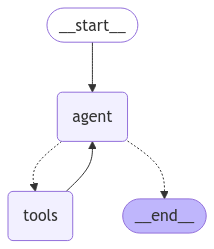

In [18]:
from io import StringIO
import sys

import os
from huggingface_hub import login
import gradio as gr
import json
import csv
import hashlib
import uuid
import logging
from typing import Annotated, List, Dict, Sequence, TypedDict

# LangChain & related imports
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langchain.embeddings import init_embeddings
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    BaseMessage,
    ToolMessage,
)

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Suppress all library logs at or below WARNING for user experience:
logging.disable(logging.WARNING)


EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents


# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

# =============================================================================
#                         Vector Store Initialisation
# =============================================================================

embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


# =============================================================================
#                         Retrieval Tools
# =============================================================================

# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="Search topic.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 2) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.
    DO NOT GIVE THE ANSWERS to Human before Human has answered all the questions.

    If Human give answers for questions you do not know, SAY you do not have the questions for the answer
    and ASK if the Human want you to generate a new quiz and then SAVE THE QUIZ with Summary Tool before ending the conversation.


    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dict of MCQ questions:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(2, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 2) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="Search text.")
    url: str = Field(
        ...,
        title="url",
        description="Web URL(s) to extract content from. If multiple URLs, separate them with a comma."
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.
    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        "Assistant should use this tool to extract content from web URLs based on user's input, "
        "Web extraction is initially load into database and then return k: Number of results to retrieve"
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Ensemble Retrieval from General and In-Memory Vector Stores
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="User query.")
    k: int = Field(5, title="Number of Results", description="Number of results.")

def ensemble_retriever(input: str, k: int = 5) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool to retrieve information from reference database and
    extraction of documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )


###############################################################################
# LLM Model Setup
###############################################################################

TEMPERATURE = 0.5
# model = ChatOpenAI(
#     model="unsloth/llama-3-8b-Instruct-bnb-4bit",
#     temperature=TEMPERATURE,
#     timeout=None,
#     max_retries=2,
#     api_key="not_required",
#     base_url="http://localhost:8000/v1",
# )

model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=TEMPERATURE,
    api_key=GROQ_API_KEY,
    verbose=True
)

###############################################################################
# 1. Initialize memory + config
###############################################################################
in_memory_store = InMemoryStore(
    index={
        "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),
        "dims": 384,  # Embedding dimensions
    }
)

# A memory saver to checkpoint conversation states
checkpointer = MemorySaver()

# Initialize config with user & thread info
config = {}
config["configurable"] = {
    "user_id": "user_1",
    "thread_id": 0,
}

###############################################################################
# 2. Define MessagesState
###############################################################################
class MessagesState(TypedDict):
    """The state of the agent.

    The key 'messages' uses add_messages as a reducer,
    so each time this state is updated, new messages are appended.
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]


###############################################################################
# 3. Memory Tools
###############################################################################
def save_memory(summary_text: str, *, config: RunnableConfig, store: BaseStore) -> str:
    """Save the given memory for the current user and return the key."""
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    namespace = (user_id, "memories")
    memory_id = thread_id
    store.put(namespace, memory_id, {"memory": summary_text})
    return f"Saved to memory key: {memory_id}"

def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Extract the messages list from the event, handling potential missing key
    messages = state["messages"]
    # Convert LangChain messages to dictionaries before storing
    messages_dict = [{"role": msg.type, "content": msg.content} for msg in messages]

    # Get the user id from the config
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    # Namespace the memory
    namespace = (user_id, "memories")
    # Create a new memory ID
    memory_id = f"{thread_id}"
    store.put(namespace, memory_id, {"memory": messages_dict})
    return f"Saved to memory key: {memory_id}"


# Define a Pydantic schema for the save_memory tool (if needed elsewhere)
# https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.InMemoryStore.html
class RecallMemory(BaseModel):
    query_text: str = Field(..., title="Search Text", description="The text to search from memories for similar records.")
    k: int = Field(5, title="Number of Results", description="Number of results to retrieve.")

def recall_memory(query_text: str, k: int = 5) -> str:
    """Retrieve user memories from in_memory_store."""
    user_id = config.get("configurable", {}).get("user_id")
    memories = [
        m.value["memory"] for m in in_memory_store.search((user_id, "memories"), query=query_text, limit=k)
        if "memory" in m.value
    ]
    return f"User memories: {memories}"

# Create a StructuredTool from the function
recall_memory_tool = StructuredTool.from_function(
    func=recall_memory,
    name="Recall Memory Tool",
    description="""
      Retrieve memories relevant to the user's query.
      """,
    args_schema=RecallMemory,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 4. Summarize Node (using StructuredTool)
###############################################################################
# Define a Pydantic schema for the Summary tool
class SummariseConversation(BaseModel):
    summary_text: str = Field(..., title="text", description="Write a summary of entire conversation here")

def summarise_node(summary_text: str):
    """
    Final node that summarizes the entire conversation for the current thread,
    saves it in memory, increments the thread_id, and ends the conversation.
    Returns a confirmation string.
    """
    user_id = config["configurable"]["user_id"]
    current_thread_id = config["configurable"]["thread_id"]
    new_thread_id = str(int(current_thread_id) + 1)

    # Prepare configuration for saving memory with updated thread id
    config_for_saving = {
        "configurable": {
            "user_id": user_id,
            "thread_id": new_thread_id
        }
    }
    key = save_memory(summary_text, config=config_for_saving, store=in_memory_store)
    #return f"Summary saved under key: {key}"

# Create a StructuredTool from the function (this wraps summarise_node)
summarise_tool = StructuredTool.from_function(
    func=summarise_node,
    name="Summary Tool",
    description="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers so the next conversation thread can continue.
      Do not reveal solutions to the user yet. Use this tool to save
      the current conversation to memory and then end the conversation.
      """,
    args_schema=SummariseConversation,
    response_format="content",
    return_direct=False,
    verbose=True
)

def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})


###############################################################################
# 5. Build the Graph
###############################################################################
graph_builder = StateGraph(MessagesState)

# Use the built-in ToolNode from langgraph that calls any declared tools.
tools = [
    mcq_retriever_tool,
    web_extraction_tool,
    ensemble_retriever_tool,
    general_retriever_tool,
    in_memory_retriever_tool,
    recall_memory_tool,
    summarise_tool,
]

tool_node = ToolNode(tools=tools)
#end_node = ToolNode(tools=[summarise_tool])

# Wrap your model with tools
llm_with_tools = model.bind_tools(tools)

###############################################################################
# 6. The agent's main node: call_model
###############################################################################
def call_model(state: MessagesState, config: RunnableConfig):
    """
    The main agent node that calls the LLM with the user + system messages.
    Since our vLLM chat wrapper expects a list of BaseMessage objects,
    we convert any dict messages to HumanMessage objects.
    If the LLM requests a tool call, we'll route to the 'tools' node next
    (depending on the condition).
    """
    # Convert message dicts to HumanMessage instances if needed.
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(HumanMessage(content=m.get("content", ""), role=m.get("role", "user")))
        else:
            messages.append(m)

    # Invoke the LLM (with tools) using the converted messages.
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}



def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})

###############################################################################
# 7. Add Nodes & Edges, Then Compile
###############################################################################
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tools", tool_node)
#graph_builder.add_node("summary", call_summary)

# Entry point
graph_builder.set_entry_point("agent")

# def custom_tools_condition(llm_output: dict) -> str:
#     """Return which node to go to next based on the LLM output."""

#     # The LLM's JSON might have a field like {"name": "Recall Memory Tool", "arguments": {...}}.
#     tool_name = llm_output.get("name", None)

#     # If the LLM calls "Summary Tool", jump directly to the 'summary' node
#     if tool_name == "Summary Tool":
#         return "summary"

#     # If the LLM calls any other recognized tool, go to 'tools'
#     valid_tool_names = [t.name for t in tools]  # all tools in the main tool_node
#     if tool_name in valid_tool_names:
#         return "tools"

#     # If there's no recognized tool name, assume we're done => go to summary
#     return "__end__"

# graph_builder.add_conditional_edges(
#     "agent",
#     custom_tools_condition,
#     {
#         "tools": "tools",
#         "summary": "summary",
#         "__end__": "summary",
#     }
# )

# If LLM requests a tool, go to "tools", otherwise go to "summary"
graph_builder.add_conditional_edges("agent", tools_condition)
#graph_builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", "__end__": "summary"})
#graph_builder.add_conditional_edges("agent", lambda llm_output: "tools" if llm_output.get("name", None) in [t.name for t in tools] else "summary", {"tools": "tools", "__end__": "summary"}

# If we used a tool, return to the agent for final answer or more tools
graph_builder.add_edge("tools", "agent")
#graph_builder.add_edge("agent", "summary")
#graph_builder.set_finish_point("summary")

# Compile the graph with checkpointing and persistent store
graph = graph_builder.compile(checkpointer=checkpointer, store=in_memory_store)

#from langgraph.prebuilt import create_react_agent
#graph = create_react_agent(llm_with_tools, tools=tool_node, checkpointer=checkpointer, store=in_memory_store)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### Gradio

In [ ]:
import gradio as gr
from gradio import ChatMessage

system_prompt = "You are a helpful Assistant. Always use the tools {tools}."

########################################
# Upload_documents
########################################

def upload_documents(file_list: List):
    """
    Load documents into in-memory vector store.
    """
    _documents = []

    for doc_path in file_list:
        _documents.extend(load_file(doc_path))

    # Split the documents into smaller chunks for better embedding coverage
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=300, # Split into chunks of 512 characters
        chunk_overlap=50, # Overlap by 50 characters
        add_start_index=True
    )
    chunked_texts = splitter.split_documents(_documents)
    in_memory_vs.add_documents(chunked_texts)
    return f"Uploaded {len(file_list)} documents into in-memory vector store."


########################################
# Submit_queries (ChatInterface Function)
########################################
def submit_queries(message, history):
    """
    - message: dict with {"text": ..., "files": [...]}
    - history: list of ChatMessage
    """
    _messages=[]
    user_text = message.get("text", "")
    user_files = message.get("files", [])

    # Process user-uploaded files
    if user_files:
      for file_obj in user_files:
          _messages.append(ChatMessage(role="user", content=f"Uploaded file: {file_obj}"))
      upload_response = upload_documents(user_files)
      _messages.append(ChatMessage(role="assistant", content=upload_response))
      yield _messages
      return # Exit early since we don't need to process text or call the LLM

    # Append user text if present
    if user_text:
        events = graph.stream(
      {
          "messages": [
              {"role": "system", "content": system_prompt},
              {"role": "user",   "content": user_text},
          ]
        },
        config,
        stream_mode="values"
        )

        for event in events:
          response =  event["messages"][-1]
          if isinstance(response, AIMessage):
            if "tool_calls" in response.additional_kwargs:
              _messages.append(
                  ChatMessage(role="assistant",
                              content=str(response.tool_calls[0]["args"]),
                              metadata={"title": str(response.tool_calls[0]["name"]),
                                        "id": config["configurable"]["thread_id"]
                                        }
                              ))
              yield _messages
            else:
              _messages.append(ChatMessage(role="assistant",
                                           content=response.content,
                                           metadata={"id": config["configurable"]["thread_id"]
                                                     }
                                           ))
              yield _messages




########################################
# 3) Save Chat History
########################################
CHAT_HISTORY_FILE = "chat_history.json"

def save_chat_history(history):
    """
    Saves the chat history into a JSON file.
    """
    session_history = [
        {
            "role": "user" if msg.is_user else "assistant",
            "content": msg.content
        }
        for msg in history
    ]
    with open(CHAT_HISTORY_FILE, "w", encoding="utf-8") as f:
        json.dump(session_history, f, ensure_ascii=False, indent=4)


########################################
# 6) Main Gradio Interface
########################################
with gr.Blocks(theme="ocean") as AI_Tutor:
    gr.Markdown("# AI Tutor Chatbot (Gradio App)")

    # Primary Chat Interface
    chat_interface = gr.ChatInterface(
        fn=submit_queries,
        type="messages",
        chatbot=gr.Chatbot(
            label="Chat Window",
            height=500
        ),
        textbox=gr.MultimodalTextbox(
            file_count="multiple",
            file_types=None,
            sources="upload",
            label="Type your query here:",
            placeholder="Enter your question...",
        ),
        title="AI Tutor Chatbot",
        description="Ask me anything about Artificial Intelligence!",
        multimodal=True,
        save_history=True,
    )


if __name__ == "__main__":
    AI_Tutor.launch(inline=True, debug=True)
